# Departamento de Engenharia de Teleinformática
# Curso de Graduação em Engenharia de Telecomuniucações
# TI0077 - Inteligência Computacional Aplicada
## Homework 02 - Models for regression - Part 1/2

### Alunos:

- Ezequias Márcio Silva de Santana Júnior - 371887
- Ingrid Simões Moreira Furtado - 375147
- Yuri Sales Ribeiro - 375177

#### Observações:
Para utilizar esse notebook é necessario ter Python3 instalado, juntamente com os pacotes listados abaixo:

- ```numpy 1.16.2```
- ```pandas 0.24.2```
- ```matplotlib 3.0.3```
- ```seaborn 0.9.0```

Este notebook, os dados utilizados e eventuais tabelas e figuras salvas encontam-se disponiveis no seguinte 
repositório: https://github.com/ezequiasjunior/ica2019.2

Ao executar este notebook localmente, serão gerados arquivos ```.pdf``` e tabelas ```.xlsx```, ```.tex```.

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
np.set_printoptions(3)

In [81]:
# Usefull funtions:
def empirical_cdf(data):
    # Calculates the empirical cdf of the given data returning the ordered data 
    # values (x) and the cumulative sum of the probabilities (y).
    x, y = np.unique(data, return_counts=True)
    return x, np.cumsum(y)/data.size

def split_data(data, rate):
    # splits up a dataset in a given ratio, returning the train and test sets.
    # number of observations:
    n = data.shape[0]
    # permute the indices randomly:
    idx = np.random.permutation(n)
    train_set = data.iloc[idx[:int(n*rate)]] # train: n*rate frist rows
    valid_set = data.iloc[idx[int(n*rate):]] # validation: the rest
    return train_set, valid_set

def box_values(data):
    # Extract the lower and uper bounds of the boxplot.
    median = np.median(data)
    upper_quartile = np.percentile(data, 75)
    lower_quartile = np.percentile(data, 25)

    iqr = upper_quartile - lower_quartile
    upper = data[data<=upper_quartile + 1.5*iqr].max()
    lower = data[data>=lower_quartile - 1.5*iqr].min()
    perc = 100 - 100*(data.size - data[data<=upper].size)/data.size
    return lower, upper, perc

## O Conjunto de Dados

O conjunto de dados selecionado foi obtido na plataforma Kaggle através do endereço: 
https://www.kaggle.com/valeriol93/predict-qoe/. Esse conjunto consiste em várias observações referentes à 
indicadores de desempenho obtidas em campanhas de testes de chamadas de voz realizadas com smartphones em uma 
rede sem-fio. O objetivo com o uso desse conjunto de dados é prever o nível de qualidade de experiência dos 
usuários, no caso o Mean Opinion Score (MOS), de acordo com outros indicadores-chave de desempenho (KPI's).

Os dados disponíveis consistem inicialmente em $N=105828$ amostras com $D=8$ preditores, correspondendo aos indicadores: ```['Date Of Test', 'Signal (dBm)', 'Speed (m/s)', 'Distance from site (m)', 'Call Test Duration (s)', 'Call Test Result', 'Call Test Technology', 'Call Test Setup Time (s)']``` juntamente com o respectivo valor de MOS como a saída do modelo a ser considerado no trabalho.

## Pré-processamento

In [3]:
# Importing dataset:
mos_data_raw = pd.read_excel('dataset_raw.xlsx')

# Display data info:
print('\nData info:\n')
display(mos_data_raw.info())
display(mos_data_raw.describe().T)
# Sum of NaN data:
total_NaN = mos_data_raw.isna().sum().sum()
# Total of valid data:
total_data = mos_data_raw.dropna().shape[0]
# Percentage of null data:
loss_NaN = 100 - 100*(total_data - total_NaN)/total_data
print(f'\nTotal of null values: {total_NaN} ({loss_NaN:.3})%')
mos_data_raw.head()


Data info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105828 entries, 0 to 105827
Data columns (total 9 columns):
Date Of Test                105828 non-null datetime64[ns]
Signal (dBm)                105821 non-null float64
Speed (m/s)                 105828 non-null float64
Distance from site (m)      95469 non-null float64
Call Test Duration (s)      105828 non-null float64
Call Test Result            105828 non-null object
Call Test Technology        105828 non-null object
Call Test Setup Time (s)    105828 non-null float64
MOS                         105828 non-null float64
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 7.3+ MB


None

,count,mean,std,min,25%,50%,75%,max
Signal (dBm),105821.0,-78.653623,18.631699,-140.00,-92.00,-79.00,-63.00,-51.000000
Speed (m/s),105828.0,8.629296,18.008427,-1.00,0.00,0.00,7.77,86.310516
Distance from site (m),95469.0,7797.172461,49584.213355,1.41,236.58,430.35,789.96,745483.680000
Call Test Duration (s),105828.0,84.202264,66.250741,12.90,60.00,90.00,90.00,900.000000
Call Test Setup Time (s),105828.0,2.662776,2.057087,0.00,0.64,3.51,4.08,45.330000
MOS,105828.0,3.105864,1.252348,1.00,2.10,3.10,4.40,4.400000



Total of null values: 10366 (10.9)%


,Date Of Test,Signal (dBm),Speed (m/s),Distance from site (m),Call Test Duration (s),Call Test Result,Call Test Technology,Call Test Setup Time (s),MOS
0,2017-07-01 00:00:27,-61.0,68.800003,1048.60,90.0,SUCCESS,UMTS,0.56,2.1
1,2017-07-01 00:02:57,-61.0,68.769997,1855.54,90.0,SUCCESS,UMTS,0.45,3.2
2,2017-07-01 00:05:29,-71.0,69.169998,1685.62,90.0,SUCCESS,UMTS,0.51,2.1
3,2017-07-01 00:08:02,-65.0,69.279999,1770.92,90.0,SUCCESS,UMTS,0.00,1.0
4,2017-07-01 00:10:30,-103.0,0.820000,256.07,60.0,SUCCESS,UMTS,3.35,3.6


Como observado acima, primeiramente faz-se necessário o tratamento das variáveis nulas que representam $10.9\%$ dos
dados, removendo as observações (rows) que contém dados NaN (not a number).

In [4]:
# Discarding rows whit NaN values:
mos_data = mos_data_raw.dropna()
# Null data info:
print('\nNon-null data info:\n')
display(mos_data.info())
display(mos_data.describe().T)


Non-null data info:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95466 entries, 0 to 105827
Data columns (total 9 columns):
Date Of Test                95466 non-null datetime64[ns]
Signal (dBm)                95466 non-null float64
Speed (m/s)                 95466 non-null float64
Distance from site (m)      95466 non-null float64
Call Test Duration (s)      95466 non-null float64
Call Test Result            95466 non-null object
Call Test Technology        95466 non-null object
Call Test Setup Time (s)    95466 non-null float64
MOS                         95466 non-null float64
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 7.3+ MB


None

,count,mean,std,min,25%,50%,75%,max
Signal (dBm),95466.0,-77.673088,18.222605,-140.00,-89.00,-79.000,-63.00,-51.000000
Speed (m/s),95466.0,8.149201,17.430856,-1.00,0.00,0.000,7.24,86.310516
Distance from site (m),95466.0,7797.355959,49584.980608,1.41,236.58,430.315,789.96,745483.680000
Call Test Duration (s),95466.0,83.893722,66.531138,12.90,60.00,90.000,90.00,900.000000
Call Test Setup Time (s),95466.0,2.756107,2.035408,0.00,0.67,3.570,4.10,45.330000
MOS,95466.0,3.053933,1.248288,1.00,2.10,2.700,4.40,4.400000


Para tratar os preditores categóricos `Call Test Result` e `Call Test Technology`, primeiramente observamos o quanto 
que eles compõe os dados observados:

In [5]:
# Categorical data summary:
results = mos_data['Call Test Result'].value_counts()
tech = mos_data['Call Test Technology'].value_counts()
print(f''' Qt. of categorical data:\n\n{results}\n\n{tech}\n
Percentage of catecorical data:\n
{100 - 100 * (total_data - results)/total_data}\n
{100 - 100 * (total_data - tech)/total_data}''')

 Qt. of categorical data:

SUCCESS                 94962
FAILURE - DROP CALL       469
FAILURE - SETUP FAIL       35
Name: Call Test Result, dtype: int64

UMTS    68340
LTE     26326
GSM       800
Name: Call Test Technology, dtype: int64

Percentage of catecorical data:

SUCCESS                 99.472063
FAILURE - DROP CALL      0.491274
FAILURE - SETUP FAIL     0.036662
Name: Call Test Result, dtype: float64

UMTS    71.585695
LTE     27.576310
GSM      0.837995
Name: Call Test Technology, dtype: float64


Como 99.5% dos dados o preditor `Call Test Result` encontra-se no estado `'SUCCESS'`, podemos selecionar entre os dados apenas as observações com esse estado com o propósito de reduzir o conjunto de dados:

In [6]:
# Select only rows with 'SUCCESS':
mask = mos_data['Call Test Result'] == 'SUCCESS'
# Changing dataset:
target_data = mos_data[mask]
total_data = target_data.shape[0]
# Resulting data:
results = target_data['Call Test Result'].value_counts()
tech = target_data['Call Test Technology'].value_counts()
print(f''' Qt. of categorical data after reduction:\n\n{results}\n\n{tech}\n
Percentage of catecorical data:\n
{100 - 100 * (total_data - results)/total_data}\n
{100 - 100 * (total_data - tech)/total_data}\n''')

 Qt. of categorical data after reduction:

SUCCESS    94962
Name: Call Test Result, dtype: int64

UMTS    68025
LTE     26162
GSM       775
Name: Call Test Technology, dtype: int64

Percentage of catecorical data:

SUCCESS    100.0
Name: Call Test Result, dtype: float64

UMTS    71.633917
LTE     27.549967
GSM      0.816116
Name: Call Test Technology, dtype: float64



Observando a quantidade dos dados do preditor `Call Test Technology`, notamos que os testes para usuários 
utilizando a tecnologia `UMTS`(3G) totalizam $72\%$ das observações.

Para um resultado mais consistente dos modelos de regressão que serão aplicados nesse trabalho, é interesante 
restringir a análise dos dados apenas para o subconjunto de usuários utilizando o 3G, visto que tecnologias mais 
atuais promovem indices de qualidade melhores com KPI's inferiores, como ilustrado abaixo o pela distribuição de MOS 
entre as tecnologias `UMTS` e `LTE`(4G).

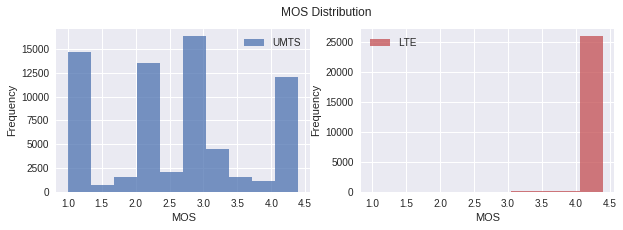

In [7]:
# Divide data into groups w.r.t each tech:
tech = target_data.groupby('Call Test Technology')
umts = tech.get_group('UMTS')
lte = tech.get_group('LTE')
# Plot histograms of MOS distribution:
fig, ax = plt.subplots(1, 2, figsize=(10, 3)) 
umts['MOS'].plot.hist(label='UMTS', color= 'C0', alpha=.75, ax=ax[0])
lte['MOS'].plot.hist(label='LTE', color='C2', alpha=.75, ax=ax[1])
plt.suptitle('MOS Distribution')
ax[0].set_xlabel('MOS')
ax[1].set_xlabel('MOS')
ax[0].legend()
ax[1].legend()
plt.show()
# plt.savefig('hw02-figs/3g4gmos.pdf')

Assim, reduzimos o conjunto de dados, selecionando o conjunto da tecnologia `UMTS`, descatando a porção de 
observações da tecnologia `GSM` $(<1\%)$ e retiramos as colunas `Call Test Result` e `Call Test Technology`, eliminando os preditores categóricos.

In [8]:
# Select only rows corresponding to UMTS technology:
target_data = umts
# Resume data:
display(target_data.info())
display(target_data.head(3))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68025 entries, 0 to 105810
Data columns (total 9 columns):
Date Of Test                68025 non-null datetime64[ns]
Signal (dBm)                68025 non-null float64
Speed (m/s)                 68025 non-null float64
Distance from site (m)      68025 non-null float64
Call Test Duration (s)      68025 non-null float64
Call Test Result            68025 non-null object
Call Test Technology        68025 non-null object
Call Test Setup Time (s)    68025 non-null float64
MOS                         68025 non-null float64
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 5.2+ MB


None

,Date Of Test,Signal (dBm),Speed (m/s),Distance from site (m),Call Test Duration (s),Call Test Result,Call Test Technology,Call Test Setup Time (s),MOS
0,2017-07-01 00:00:27,-61.0,68.800003,1048.60,90.0,SUCCESS,UMTS,0.56,2.1
1,2017-07-01 00:02:57,-61.0,68.769997,1855.54,90.0,SUCCESS,UMTS,0.45,3.2
2,2017-07-01 00:05:29,-71.0,69.169998,1685.62,90.0,SUCCESS,UMTS,0.51,2.1


In [9]:
# Removing 'Call Test Result' and 'Call Test Technology' columns:
target_data = target_data.drop(columns=['Call Test Result','Call Test Technology'])
display(target_data.head(3))
target_data.describe().T

,Date Of Test,Signal (dBm),Speed (m/s),Distance from site (m),Call Test Duration (s),Call Test Setup Time (s),MOS
0,2017-07-01 00:00:27,-61.0,68.800003,1048.60,90.0,0.56,2.1
1,2017-07-01 00:02:57,-61.0,68.769997,1855.54,90.0,0.45,3.2
2,2017-07-01 00:05:29,-71.0,69.169998,1685.62,90.0,0.51,2.1


,count,mean,std,min,25%,50%,75%,max
Signal (dBm),68025.0,-69.861404,13.852989,-133.00,-81.00,-71.00,-55.000000,-51.000000
Speed (m/s),68025.0,9.025756,18.374011,-1.00,0.00,0.00,8.210054,86.310516
Distance from site (m),68025.0,7335.334470,49310.397384,1.41,238.43,429.64,716.670000,745483.680000
Call Test Duration (s),68025.0,85.057796,73.999317,14.61,60.00,90.00,90.000000,900.000000
Call Test Setup Time (s),68025.0,3.537113,1.823622,0.00,3.46,3.87,4.270000,45.330000
MOS,68025.0,2.553017,1.116165,1.00,2.10,2.70,3.200000,4.400000


Para o preditor `Date Of Test`, extraímos a informação da hora que o teste foi feito, visto que o horário do dia 
pode trazer informações sobre a quantidade de tráfego na rede naquele determinado horário o que contribui para o 
nível de qualidade experienciada.

In [10]:
# Extract hour information of Date Of Test column:
date_of_test = target_data['Date Of Test']
test_hour = date_of_test.apply(lambda dt: dt.hour)

# Visualizing:
# plt.figure()
# plt.scatter(np.arange(10000), test_hour.values[:10000], c=target_data['MOS'][:10000], cmap= 'viridis', marker='x')
# plt.colorbar()

# Add hour column to dataframe and drop the column 'Date Of Test'
target_data = target_data.drop(columns='Date Of Test')
target_data.insert(0, 'Test Hour', test_hour)
display(target_data.head())
display(target_data.describe().T)

,Test Hour,Signal (dBm),Speed (m/s),Distance from site (m),Call Test Duration (s),Call Test Setup Time (s),MOS
0,0,-61.0,68.800003,1048.60,90.0,0.56,2.1
1,0,-61.0,68.769997,1855.54,90.0,0.45,3.2
2,0,-71.0,69.169998,1685.62,90.0,0.51,2.1
3,0,-65.0,69.279999,1770.92,90.0,0.00,1.0
4,0,-103.0,0.820000,256.07,60.0,3.35,3.6


,count,mean,std,min,25%,50%,75%,max
Test Hour,68025.0,12.639926,6.018312,0.00,8.00,13.00,18.000000,23.000000
Signal (dBm),68025.0,-69.861404,13.852989,-133.00,-81.00,-71.00,-55.000000,-51.000000
Speed (m/s),68025.0,9.025756,18.374011,-1.00,0.00,0.00,8.210054,86.310516
Distance from site (m),68025.0,7335.334470,49310.397384,1.41,238.43,429.64,716.670000,745483.680000
Call Test Duration (s),68025.0,85.057796,73.999317,14.61,60.00,90.00,90.000000,900.000000
Call Test Setup Time (s),68025.0,3.537113,1.823622,0.00,3.46,3.87,4.270000,45.330000
MOS,68025.0,2.553017,1.116165,1.00,2.10,2.70,3.200000,4.400000


Agora, os conjunto de dados consiste em $N=68025$ amostras com $D=6$ preditores.

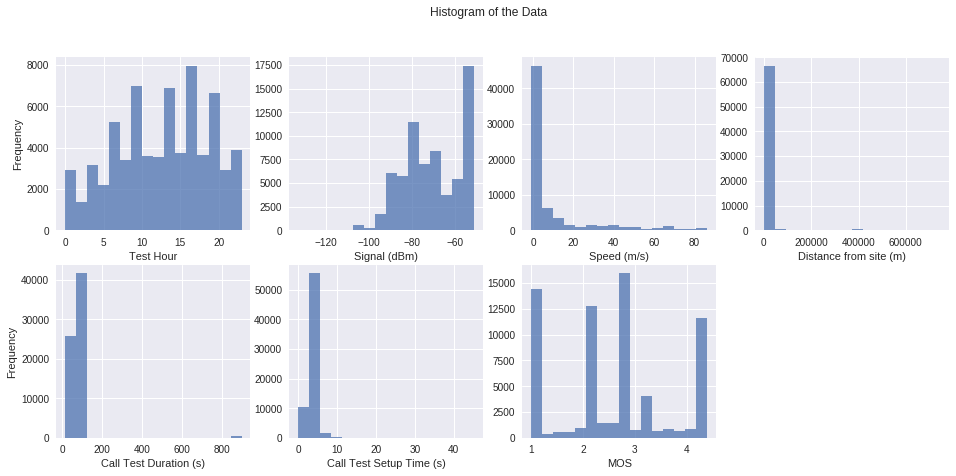

In [11]:
# Visualizing data distribution:
fig, ax = plt.subplots(2, 4, figsize=(16, 7)) 
ax = ax.ravel()
fig.suptitle('Histogram of the Data')
for i in range(0, 7):
    ax[i].set_xlabel(target_data.columns[i])
    ax[0].set_ylabel('Frequency')
    ax[4].set_ylabel('Frequency')
    ax[i].hist(target_data.iloc[:, i], bins=16, alpha=.75)
fig.delaxes(ax[7])
# plt.savefig('hw02-figs/hist_data.pdf')

Continuando a heurística para o problema, trataremos dos dados inconsistentes em relação o cenário das medições.

Observando a distribuição os valores do preditor `Distance from site (m)`, notamos a presença de outliers com 
valores de distância entre usuário e uma base muito acima do máximo que uma estação rádio-base(BS) pode atender (valores 
acima do 3º Quaril na ordem de 10^3).

Para filtrar estes valores, primeiramente observamos o box plot das amostras e sua cdf empírica a fim de encontrar 
um valor máximo para a distância que seja rasoável, descartando as amostras ruidosas.

87.6% of the observations corresponding to values of distance <= 1432.96 m


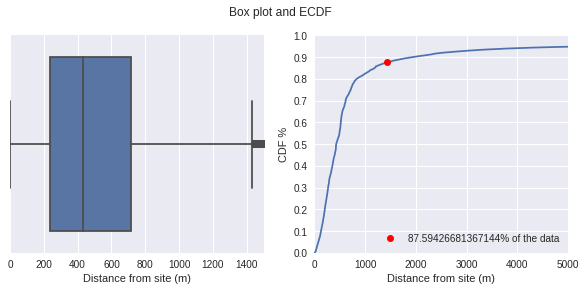

In [52]:
# Considering the first 10000 m:
# Box plot of the distance values:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plt.suptitle('Box plot and ECDF')
sns.boxplot(target_data.iloc[:,3], ax=ax[0])
ax[0].set_xlim(0, 1500)

# Empirical CDF:
x, y = empirical_cdf(target_data.iloc[:,3])
ax[1].plot(x,y)
ax[1].set_xlabel('Distance from site (m)')
ax[1].set_ylabel('CDF %')
ax[1].axis([0,5000,0,1])
ax[1].set_yticks(np.arange(11)/10)

# Select a certain percentage of the total of observations based of the analisys of the box plot:
l, dist_upper, perc = box_values(target_data.iloc[:,3])
p = np.where(y>=perc/100)[0][0]
ax[1].plot(x[p], y[p], 'ro', label=f'{perc:.3}% of the data')
ax[1].legend()
print(f'{perc:.3}% of the observations corresponding to values of distance <= {x[p]} m')
plt.show()
# plt.savefig('hw02-figs/dist.pdf')

Analisando os gráficos acima, conclui-se que a maioria significativa dos usuários encontra se num ráio de $1433m$ da 
estação rádio-base, que é um valor de ráio de cobertura de acordo com o máximo usual para um cemário macrocelular 
urbano.

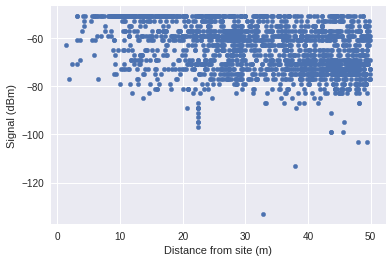

In [49]:
# View the relationship between the predictors 'Distance from site (m)' and 'Signal (dBm)':
# for a minimum distance of de BS of 50m
mask = (target_data.iloc[:,3] <= 50)
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
target_data[mask].plot.scatter('Distance from site (m)','Signal (dBm)', ax=ax)
plt.show()
#

A partir do gráfico acima, nota-se a presença de valores discrepantes com a realidade, onde a uma distância pequena 
da BS, usuários apresentam níveis de sinal recebido abaixo de $-80dBm$.

Removendo as amostras inconsistentes, tem-se:

,count,mean,std,min,25%,50%,75%,max
Test Hour,58565.0,12.446325,6.090018,0.00,8.00,13.00,17.00,23.000000
Signal (dBm),58565.0,-70.934995,13.628709,-113.00,-81.00,-73.00,-57.00,-51.000000
Speed (m/s),58565.0,6.215078,14.492970,-1.00,0.00,0.00,5.45,86.180145
Distance from site (m),58565.0,439.678626,283.233955,35.09,222.76,394.22,567.07,1432.960000
Call Test Duration (s),58565.0,84.071127,72.872784,14.61,60.00,90.00,90.00,900.000000
Call Test Setup Time (s),58565.0,3.618218,1.595658,0.00,3.52,3.88,4.26,45.330000
MOS,58565.0,2.541877,1.111349,1.00,2.10,2.70,3.20,4.400000


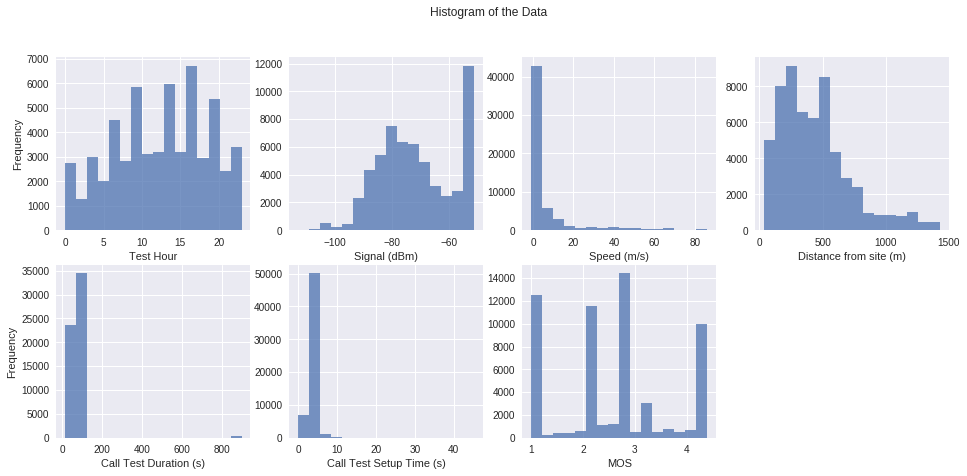

In [53]:
# Select only rows corresponding to distances between 35m and 5565m:
mask = (target_data.iloc[:,3] >= 35) & (target_data.iloc[:,3] <= np.round(dist_upper))
target_data = target_data[mask]
# Resume data:
display(target_data.describe().T)

# Visualizing data distribution:
fig, ax = plt.subplots(2, 4, figsize=(16, 7)) 
ax = ax.ravel()
fig.suptitle('Histogram of the Data')
for i in range(0, 7):
    ax[i].set_xlabel(target_data.columns[i])
    ax[0].set_ylabel('Frequency')
    ax[4].set_ylabel('Frequency')
    ax[i].hist(target_data.iloc[:, i], bins=16, alpha=.75)
fig.delaxes(ax[7])
# plt.savefig('hw02-figs/hist_data.pdf')

Com a descrição dos dados acima, para o preditor `Speed (m/s)` é necessário tratar também as observações que possuem 
valores de velocidade menores do que $0m/s$:

In [54]:
# Qt. rows with speed < 0:
mask = target_data.iloc[:,2] < 0
print(f'Qt. of invalid speed data: {target_data[mask].shape[0]}')
# Removing rows of speed values < 0:
mask = target_data.iloc[:,2] >= 0
target_data = target_data[mask]
display(target_data.describe().T)

Qt. of invalid speed data: 6487


,count,mean,std,min,25%,50%,75%,max
Test Hour,52078.0,12.524290,6.035990,0.00,8.0000,13.000,17.00,23.000000
Signal (dBm),52078.0,-70.318849,13.159912,-113.00,-81.0000,-73.000,-59.00,-51.000000
Speed (m/s),52078.0,7.113811,15.130049,0.00,0.0000,0.000,6.96,86.180145
Distance from site (m),52078.0,419.758513,274.758235,35.09,213.5425,370.095,535.95,1432.960000
Call Test Duration (s),52078.0,82.944107,74.270294,14.61,60.0000,90.000,90.00,900.000000
Call Test Setup Time (s),52078.0,3.576816,1.634569,0.00,3.4900,3.850,4.24,45.330000
MOS,52078.0,2.554893,1.108814,1.00,2.1000,2.700,3.20,4.400000


88.0% of the observations corresponding to values of Speed <= 17.3999996185303 m/s


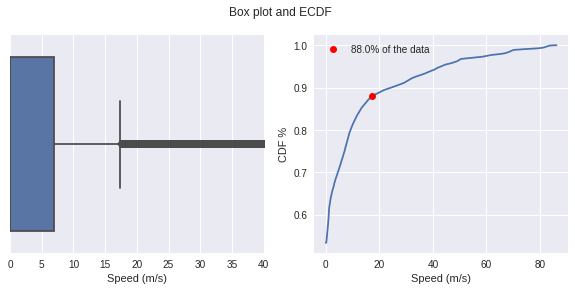

In [57]:
# Box plot of the Speed values:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plt.suptitle('Box plot and ECDF')
sns.boxplot(target_data.iloc[:,2], ax=ax[0])
ax[0].set_xlim(0, 40)

# Empirical CDF:
x, y = empirical_cdf(target_data.iloc[:,2])
ax[1].plot(x,y)
ax[1].set_xlabel('Speed (m/s)')
ax[1].set_ylabel('CDF %')
ax[1].set_yticks(np.arange(11)/10)

# Select a certain percentage of the total of observations:
l, spd_upper, perc = box_values(target_data.iloc[:,2])

p = np.where(y>=perc/100)[0][0]
ax[1].plot(x[p], y[p], 'ro', label=f'{perc:.3}% of the data')
ax[1].legend()
print(f'{perc:.3}% of the observations corresponding to values of Speed <= {x[p]} m/s')
plt.show()
# plt.savefig('hw02-figs/speed.pdf')

Analisando os gráficos acima, conclui-se que a maioria significativa dos usuários encontra-se a uma velocidade de 
$17.4m/s$. Filtrando os dados tem-se:

,count,mean,std,min,25%,50%,75%,max
Test Hour,45731.0,12.291946,6.105360,0.00,8.0,13.00,17.000,23.00
Signal (dBm),45731.0,-71.976427,12.528245,-113.00,-81.0,-73.00,-63.000,-51.00
Speed (m/s),45731.0,2.203057,3.952887,0.00,0.0,0.00,2.520,17.00
Distance from site (m),45731.0,383.594292,237.951848,35.09,206.3,345.89,519.175,1432.96
Call Test Duration (s),45731.0,81.653470,75.401508,47.08,60.0,89.71,90.000,900.00
Call Test Setup Time (s),45731.0,3.558409,1.475102,0.00,3.5,3.83,4.190,45.33
MOS,45731.0,2.505508,1.105191,1.00,2.0,2.70,2.700,4.40


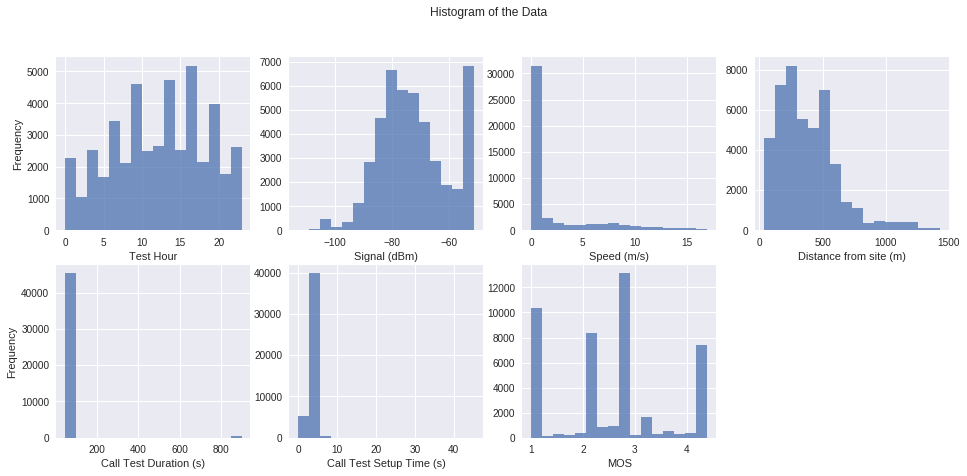

In [58]:
# Removing rows of speed values > 17.5:
mask = target_data.iloc[:,2] <= np.round(spd_upper)
target_data = target_data[mask]
display(target_data.describe().T)
# Visualizing data distribution:
fig, ax = plt.subplots(2, 4, figsize=(16, 7)) 
ax = ax.ravel()
fig.suptitle('Histogram of the Data')
for i in range(0, 7):
    ax[i].set_xlabel(target_data.columns[i])
    ax[0].set_ylabel('Frequency')
    ax[4].set_ylabel('Frequency')
    ax[i].hist(target_data.iloc[:, i], bins=16, alpha=.75)
fig.delaxes(ax[7])
# plt.savefig('hw02-figs/hist_data.pdf')

Por fim, analisando o preditor `Call Test Duration`, tem-se o boxplot e ECDF abaixo, que nos leva a filtrar os dados novamente, removendo as observações contendo os outliers desse preditor.

99.2% of the observations corresponding to values of test duration time <= 90.0 s


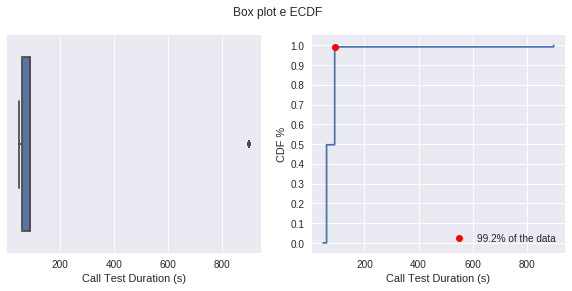

In [68]:
# Box plot of the 'Call Test Duration' and Call Test Setup Time:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plt.suptitle('Box plot e ECDF')
sns.boxplot(target_data.iloc[:,4], ax=ax[0])
# ax[0].set_xlim(0, 40)

# Empirical CDF:
x, y = empirical_cdf(target_data.iloc[:,4])
ax[1].plot(x,y)
ax[1].set_xlabel('Call Test Duration (s)')
ax[1].set_ylabel('CDF %')
ax[1].set_yticks(np.arange(11)/10)

# Select a certain percentage of the total of observations:
l1, dt_upper, perc = box_values(target_data.iloc[:,4])

p = np.where(y>=perc/100)[0][0]
ax[1].plot(x[p], y[p], 'ro', label=f'{perc:.3}% of the data')
ax[1].legend()
print(f'{perc:.3}% of the observations corresponding to values of test duration time <= {x[p]} s')
plt.show()
# plt.savefig('hw02-figs/speed.pdf')

,count,mean,std,min,25%,50%,75%,max
Test Hour,45361.0,12.296135,6.099200,0.00,8.00,13.00,17.00000,23.00
Signal (dBm),45361.0,-71.997707,12.545163,-113.00,-81.00,-73.00,-63.00000,-51.00
Speed (m/s),45361.0,2.212645,3.959077,0.00,0.00,0.00,2.55566,17.00
Distance from site (m),45361.0,383.261493,238.618169,35.09,205.56,343.14,519.47000,1432.96
Call Test Duration (s),45361.0,74.978603,14.996911,47.08,60.00,60.00,90.00000,90.00
Call Test Setup Time (s),45361.0,3.557201,1.466274,0.00,3.50,3.83,4.19000,45.33
MOS,45361.0,2.510416,1.107152,1.00,2.10,2.70,2.70000,4.40


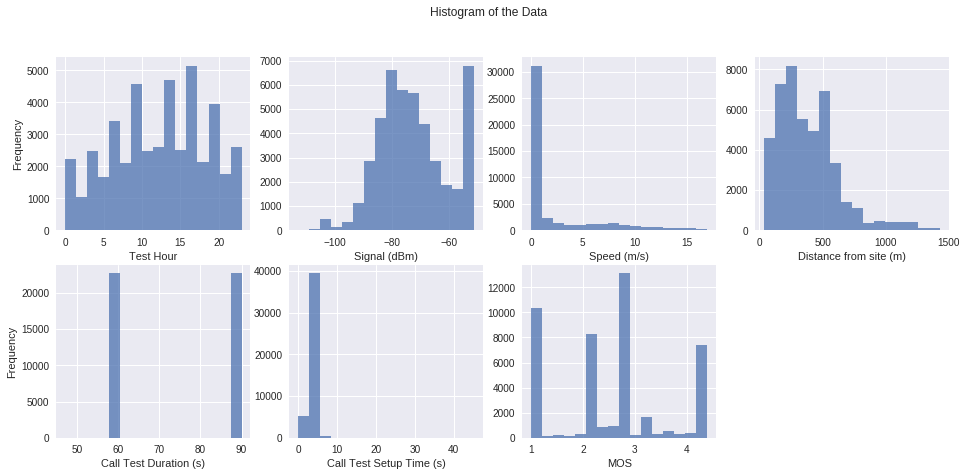

In [69]:
# Filtering the data w.r.t. Call Test Duration:
# Removing rows of test duration > 90 s:
mask = target_data.iloc[:,4] <= np.round(dt_upper)
target_data = target_data[mask]
display(target_data.describe().T)
# Visualizing data distribution:
fig, ax = plt.subplots(2, 4, figsize=(16, 7)) 
ax = ax.ravel()
fig.suptitle('Histogram of the Data')
for i in range(0, 7):
    ax[i].set_xlabel(target_data.columns[i])
    ax[0].set_ylabel('Frequency')
    ax[4].set_ylabel('Frequency')
    ax[i].hist(target_data.iloc[:, i], bins=16, alpha=.75)
fig.delaxes(ax[7])
# plt.savefig('hw02-figs/hist_data.pdf')

In [75]:
# Saving the data after heuristics:
target_data.to_excel('trated_mos_data.xlsx', index=False)

### Divisão do conjunto de dados em conjunto de treino e validação

Nas células abaixo, os dados serão divididos e salvos em tabelas `.xlsx`, bem como será armazenado em um outro conjunto os dados de MOS como saída Y dos modelos de regressão a serem estudados.

In [83]:
# Split the dataset 1/3 = validation | 2/3 train:
train_set, valid_set = split_data(target_data, rate=2/3)

# Extract the outcome:
Y_train = train_set['MOS']
Y_valid = valid_set['MOS']

# Remove the 'MOS' cloumns of the train and validation sets:
train_set = train_set.drop(columns='MOS')
valid_set = valid_set.drop(columns='MOS')

# View:
print('Train Set:')
display(train_set.describe().T)
print('Validation Set:')
display(valid_set.describe().T)

# Saving the outcome data:
Y_train.to_excel('Y_mos_train.xlsx', index=False)
Y_valid.to_excel('Y_mos_valid.xlsx', index=False)

Train Set:


,count,mean,std,min,25%,50%,75%,max
Test Hour,30240.0,12.295503,6.099637,0.00,8.0000,13.000,17.0000,23.00
Signal (dBm),30240.0,-72.060747,12.577723,-113.00,-81.0000,-73.000,-63.0000,-51.00
Speed (m/s),30240.0,2.186891,3.933972,0.00,0.0000,0.000,2.4500,17.00
Distance from site (m),30240.0,383.369015,238.938848,35.09,205.8475,343.230,519.2025,1432.96
Call Test Duration (s),30240.0,75.006933,14.996777,59.04,60.0000,89.345,90.0000,90.00
Call Test Setup Time (s),30240.0,3.559271,1.488445,0.00,3.5000,3.830,4.1900,45.33


Validation Set:


,count,mean,std,min,25%,50%,75%,max
Test Hour,15121.0,12.297401,6.098527,0.00,8.00,13.00,17.00,23.000000
Signal (dBm),15121.0,-71.871635,12.479252,-113.00,-81.00,-73.00,-63.00,-51.000000
Speed (m/s),15121.0,2.264151,4.008447,0.00,0.00,0.00,2.80,16.990294
Distance from site (m),15121.0,383.046464,237.983301,35.24,205.18,343.11,519.81,1429.640000
Call Test Duration (s),15121.0,74.921948,14.997515,47.08,60.00,60.00,90.00,90.000000
Call Test Setup Time (s),15121.0,3.553061,1.420939,0.00,3.50,3.84,4.20,23.910000


In [ ]:
# transformar dados -> salvar
# correlações preditores... plots...unc monovariate